Using device: cuda
Files already downloaded and verified
Epoch 0, Batch: 0, Loss: 1.1006664037704468
Epoch 0, Batch: 100, Loss: 0.05721915885806084
Epoch 1, Batch: 0, Loss: 0.046665631234645844
Epoch 1, Batch: 100, Loss: 0.038200460374355316
Epoch 2, Batch: 0, Loss: 0.038914233446121216
Epoch 2, Batch: 100, Loss: 0.038987573236227036
Epoch 3, Batch: 0, Loss: 0.03645879775285721
Epoch 3, Batch: 100, Loss: 0.03979305177927017
Epoch 4, Batch: 0, Loss: 0.033843591809272766
Epoch 4, Batch: 100, Loss: 0.0397048220038414
Epoch 5, Batch: 0, Loss: 0.03663909062743187
Epoch 5, Batch: 100, Loss: 0.03392387181520462
Epoch 6, Batch: 0, Loss: 0.03412551060318947
Epoch 6, Batch: 100, Loss: 0.035960160195827484
Epoch 7, Batch: 0, Loss: 0.03484388813376427
Epoch 7, Batch: 100, Loss: 0.03422516956925392
Epoch 8, Batch: 0, Loss: 0.04125110059976578
Epoch 8, Batch: 100, Loss: 0.03260029852390289
Epoch 9, Batch: 0, Loss: 0.03478752821683884
Epoch 9, Batch: 100, Loss: 0.03307182341814041


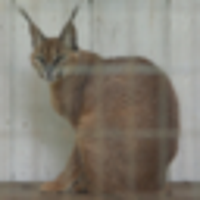

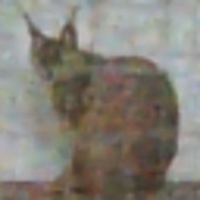

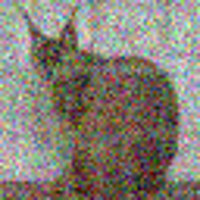

平均 MSE: 0.0017168885246657353
平均 RMSE: 0.04099745655843812


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from PIL import Image, ImageShow
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    


model = DIP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10):
    for batch_idx, (images, _) in enumerate(train_dataloader):
        images = images.to(device)
        noisy_images = images + 0.5 * torch.randn_like(images)
        
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

sample_image, _ = next(iter(train_dataloader))
sample_image = sample_image.to(device)

sample_np = sample_image[0].cpu().numpy().transpose(1, 2, 0)
sample_np = (sample_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
sample_np = np.clip(sample_np, 0, 1)
sample_pil = Image.fromarray((sample_np * 255).astype(np.uint8))

noisy_sample_image = sample_image + 0.5 * torch.randn_like(sample_image)

with torch.no_grad():
    reconstructed_image = model(noisy_sample_image)

reconstructed_image_np = reconstructed_image[0].cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = (reconstructed_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
reconstructed_image_pil = Image.fromarray((reconstructed_image_np * 255).astype(np.uint8))
reconstructed_image_pil.save('reconstructed_image.jpg')

noisy_sample_image_np = noisy_sample_image[0].cpu().numpy().transpose(1, 2, 0)
noisy_sample_image_np = (noisy_sample_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反标准化
noisy_sample_image_np = np.clip(noisy_sample_image_np, 0, 1)
noisy_sample_image_pil = Image.fromarray((noisy_sample_image_np * 255).astype(np.uint8))
noisy_sample_image_pil.save('noisy_sample_image.jpg')

from IPython.display import display
display(sample_pil.resize((200, 200)))

display(reconstructed_image_pil.resize((200, 200)))

display(noisy_sample_image_pil.resize((200, 200)))

# 計算 MSE 和 RMSE
mse_values = []
rmse_values = []

for i in range(len(reconstructed_image)):
    original_np = sample_image[i].cpu().numpy().transpose(1, 2, 0)
    original_np = (original_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反正規化
    original_np = np.clip(original_np, 0, 1)
    
    reconstructed_np = reconstructed_image[i].cpu().numpy().transpose(1, 2, 0)
    reconstructed_np = (reconstructed_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 反正規化
    reconstructed_np = np.clip(reconstructed_np, 0, 1)
    
    mse = np.mean((original_np - reconstructed_np) ** 2)
    rmse = np.sqrt(mse)
    
    mse_values.append(mse)
    rmse_values.append(rmse)

print(f'平均 MSE: {np.mean(mse_values)}')
print(f'平均 RMSE: {np.mean(rmse_values)}')
